In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy import optimize
import read_chn as rc

In [8]:
data_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/new_data/'
plot_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/plots/'

am241_data_LV = 'hp522171-am241-lv-092523.Chn'
cs137_data_LV = 'hp522171-cs137-lv-092523.Chn'

am241_data_HV = 'hp522171-am241-hv-092623.Chn'
am241_data_HV2 = 'hp522171-am241-hv-092623-ch3-1.Chn'
cs137_data_HV = 'hp522171-cs137-hv-092623.Chn'
cs137_data_HV2 = 'hp522171-cs137-hv-092623-2.Chn'

am_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/data_spe/400V-cable20-am241.Spe'
cs_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/data_spe/400V-cable19-cs137.Spe'

am_peak = 59.5
cs_peak = 661.6

In [9]:
### read_data function to get x/y data
### fit gaussian to get mean
### fit energy eq. and plot results

In [10]:
cs137_data_LV[9:14]

'cs137'

In [11]:
data = rc.gamma_data(data_path+cs137_data_LV)
data2 = rc.gamma_data(data_path+am241_data_LV)

In [12]:
data_hist = data.hist_array
data2_hist = data2.hist_array

In [13]:
x = np.arange(0,len(data_hist),1)

In [14]:
am241 = pd.read_csv(am_path, dtype=np.int32, engine='python', skiprows=12, skipfooter=15)
cs137 = pd.read_csv(cs_path, dtype=np.int32, engine='python', skiprows=12, skipfooter=19)

am_spe_u = 600
am_spe_l = 400
cs_spe_u = 6300
cs_spe_l = 6100

am_spe_p0 = [500,1500,10]
cs_spe_p0 = [6250,100,10]

In [15]:
am_lv_u = 560
am_lv_l = 480
am_hv_u = 650
am_hv_l = 385

cs_lv_u = 1145
cs_lv_l = 806
cs_hv_u = 1147
cs_hv_l = 806

am_lv_p0 = [520,3,10]
am_hv_p0 = [475,8,5]
cs_lv_p0 = [950,10,50]
cs_hv_p0 = [950,10,50]

In [16]:
# functions to be used in the curve fit and energy fit
def gauss(x, mean, amp, stdev):
    '''used to fit spectrum peak'''
    return amp * np.exp(-((x-mean)**2) / (2 * stdev**2))

def efit(x,m,b): # could be improved by including higher-order polynomial but need more data points
    '''energy = m*channel + b'''
    return m*x + b

In [17]:
def read_data(filepath,head,foot):
    '''read in .Chn and .Spe data, gives x,y [channel,data output] arrays for fitting'''
    
    if filepath[-4:]=='.Spe':
        data = pd.read_csv(filepath, dtype=np.int32, engine='python', skiprows=head, skipfooter=foot)
        data_ar = np.asarray(data)
        y = data_ar.flatten()
        x = np.arange(0,len(y),1)
        source_name = filepath[-9:-4] + '[.Spe]'
        
    if filepath[-4:]=='.Chn':
        data = rc.gamma_data(filepath)
        y = data.hist_array
        x = np.arange(0,len(y),1)
        source_name = filepath[9:14] + '[.Chn]'
        
    return x,y,source_name

In [18]:
# optimization functions
def gauss_opt(data,upper_bound,lower_bound,p0_guess,source_name):
    '''select data, apply curve_fit and print results'''
    # select data to curve-fit
    data_y = data[lower_bound:upper_bound]        
    # creating array of x-values for fit
    data_x = np.arange(lower_bound,upper_bound,1)
    
    # curve-fit to find peak
    var, cov = optimize.curve_fit(gauss, data_x, data_y, p0=p0_guess) #p0_guess = (mean, amp, stedev)
    # calculate full-width half-mass
    fwhm = 2.35*var[2]
    # calculate fitted curve
    data_fit = gauss(data_x, *var)
    # print results
    print('curve-fit results')
    print(source_name,':', var, '[mean, amp, stdev]')
    print('FWHM')
    print(source_name,':',fwhm)
    
    return data_x,data_y,data_fit,var[0],fwhm #x,y,fit,mean,fwhm

def energy_opt(peak1, peak2, mean1, mean2, x1, x2):
    '''apply curve_fit to energy function and return energy calibrated data'''
    xvals = np.array([mean1, mean2])
    yvals = np.array([peak1, peak2])
    values, cov = optimize.curve_fit(efit, xvals, yvals, p0=[1,10])
    
    print('curve-fit results:')
    print(values,'[m,b]')
    
    '''convert x-arrays from channel to energy'''
    x1_energy = efit(x1,*values)
    x2_energy = efit(x2,*values)
    
    return x1_energy,x2_energy,values

In [19]:
# plotting function
def plot_gauss(x,y,fit,mean,fwhm,source_name):
    plot_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/plots/'
    
    fig, ax1 = plt.subplots(1,1, figsize=(8,4))

    ax1.plot(x, y, c='black', linewidth=1, label='data')
    ax1.plot(x, fit, c='red', lw=1, label='fit')
    ax1.axvline(mean, c='blue', linestyle='dashed', lw=0.8, label='mean')
    ax1.set_ylabel('count')
    ax1.set_xlabel('channel')
    ax1.set_title([source_name+': FWHM=', round(fwhm,3)])
    ax1.minorticks_on()
    ax1.legend()

    fig.tight_layout()
    #plt.savefig(plot_path + source_name + '_gauss_fit.pdf',bbox_inches='tight',dpi=300)
    plt.show()
    
def plot_efit(x1,y1,x2,y2,peak1,peak2,source1,source2):
    plot_path = '/Users/angelabeatty/Documents/lbnlBLUR/coding/plots/'
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

    ax1.plot(x1, y1, c='black', linewidth=1, label='data')
    ax1.axvline(peak1, c='red', linestyle='dashed', lw=0.8, label=source1)
    ax1.axvline(peak2, c='orange', linestyle='dashed', lw=0.8, label=source2)
    ax1.set_ylabel('count')
    ax1.set_title(source1)
    ax1.set_xlim(0,max(x1))
    ax1.minorticks_on()
    ax1.legend()

    ax2.plot(x2, y2, c='black', linewidth=1, label='data')
    ax2.axvline(peak2, c='orange', linestyle='dashed', lw=0.8, label=source2)
    ax2.axvline(peak1, c='red', linestyle='dashed', lw=0.8, label=source1)
    ax2.set_xlabel('energy [keV]')
    ax2.set_ylabel('counts')
    ax2.set_title(source2)
    ax2.set_xlim(0,max(x2))
    ax2.minorticks_on()
    ax2.legend()

    fig.tight_layout()
    #plt.savefig(plot_path + source1 + source2 + '_cal.pdf',bbox_inches='tight',dpi=300)
    plt.show()

In [20]:
# fit functions for .spe files
def spect(source_name, data, peak, upper_bound, lower_bound, p0_guess, plotting=False):
    '''read in data and plot before inputting into function'''
    
    data_x,data_y,data_fit,mean,fwhm = gauss_opt(data,upper_bound,lower_bound,p0_guess,source_name)
    
    # plot fitted spectrum
    if plotting==True:
        plot_gauss(data_x,data_y,data_fit,mean,fwhm,source_name)
    
    return mean,fwhm
    
def energy_fit(peak1, peak2, mean1, mean2, data1, data2, source1, source2, plotting=False):
    '''peak1-2 known, mean1-2 are corresponding peak channels'''
    
    data1_eval,data2_eval,values = energy_opt(peak1,peak2,mean1,mean2,data1,data2)
    
    '''use source1-2 to label plots of energy calibrated spectrum'''
    if plotting==True:
        plot_efit(data1_eval,data1,data2_eval,data2,peak1,peak2,source1,source2)
    
    return values

In [21]:
### function reads in data
### .spe -> convert to array and flatten, create x-data (arange(0,len(data),1))
### .chn -> create histogram, bins=x data bin-heights=y data

curve-fit results
Cs-137 : [4350.34741935  671.93508083    9.90989049] [mean, amp, stdev]
FWHM
Cs-137 : 23.28824265737777


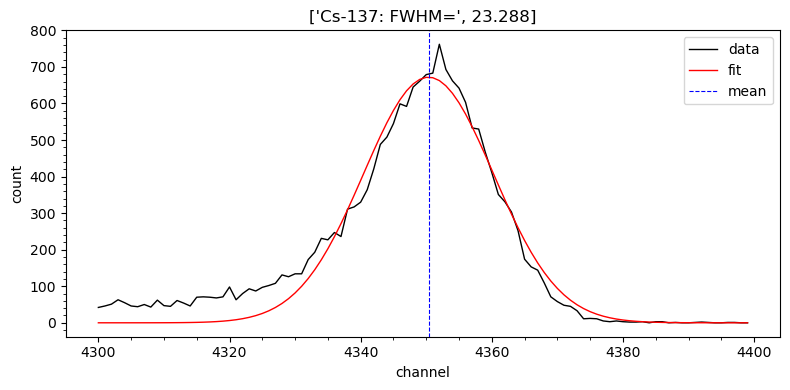

(4350.347419353008, 23.28824265737777)

In [22]:
spect('Cs-137', data_hist, cs_peak,4400,4300,[4350,1000,20],plotting=True)

curve-fit results
Am-241 : [ 391.35952777 5254.23998359    8.52692268] [mean, amp, stdev]
FWHM
Am-241 : 20.03826829654743


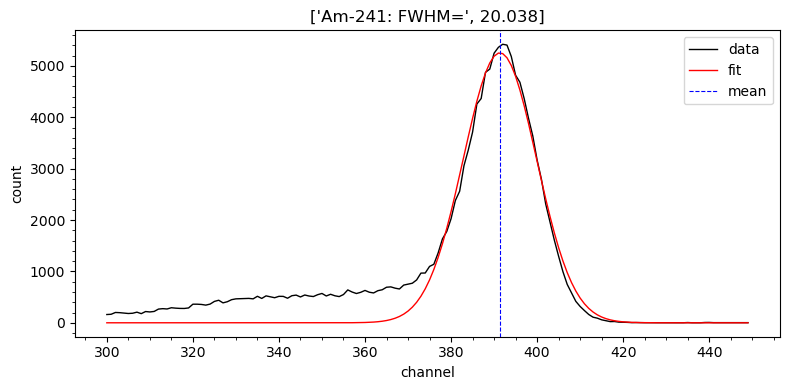

(391.35952777314594, 20.03826829654743)

In [23]:
spect('Am-241', data2_hist, am_peak,450,300,[400,5000,10],plotting=True)

/Users/angelabeatty/opt/anaconda3/envs/school/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


curve-fit results:
[0.15208386 0.03521091] [m,b]


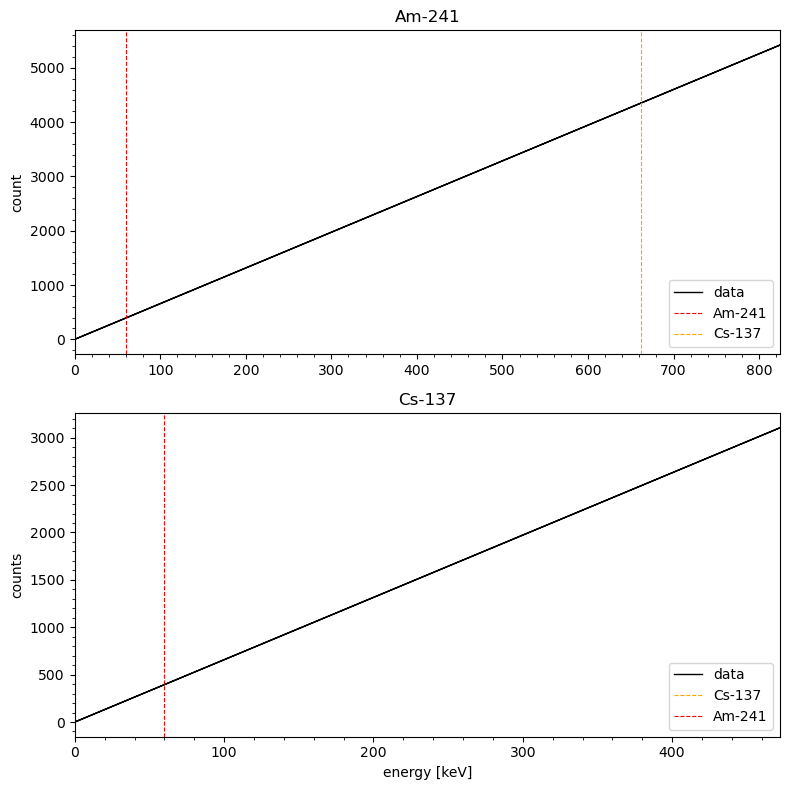

array([0.15208386, 0.03521091])

In [25]:
energy_fit(am_peak,cs_peak, 391, 4350, data2_hist, data_hist, 'Am-241', 'Cs-137', plotting=True)